# Import

In [1]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
from src.particle import *
from src.tracker import *
from src.widgets import *
import warnings
warnings.filterwarnings('ignore')

# Tracking

In [2]:
def track_values(p, charge=1., B=1.):
    return p/(charge*B)

In [3]:
# load in data

data = pd.read_hdf('EEEE/0_allcomb_0.h5')
coords = [f'{i}' for i in np.arange(0, 6624)]
hits = data[coords]
momenta = data.loc[:,['phi', 'pt']]
momenta.loc[:,'charge'] = data.loc[:,'pdg']/abs(data.loc[:,'pdg'])
momenta.loc[:,'phi'] = momenta.loc[:,'phi']*np.pi/180.
momenta.reset_index(inplace = True)
momenta

,index,phi,pt,charge
0,0,-0.272405,4.246419,-1.0
1,0,-2.578635,0.635968,-1.0
2,0,1.774206,0.368985,1.0
3,0,2.786167,3.223214,1.0


In [4]:
tw = TrackingWidget(momenta.loc[:1,:], B = 0.1)

Output()

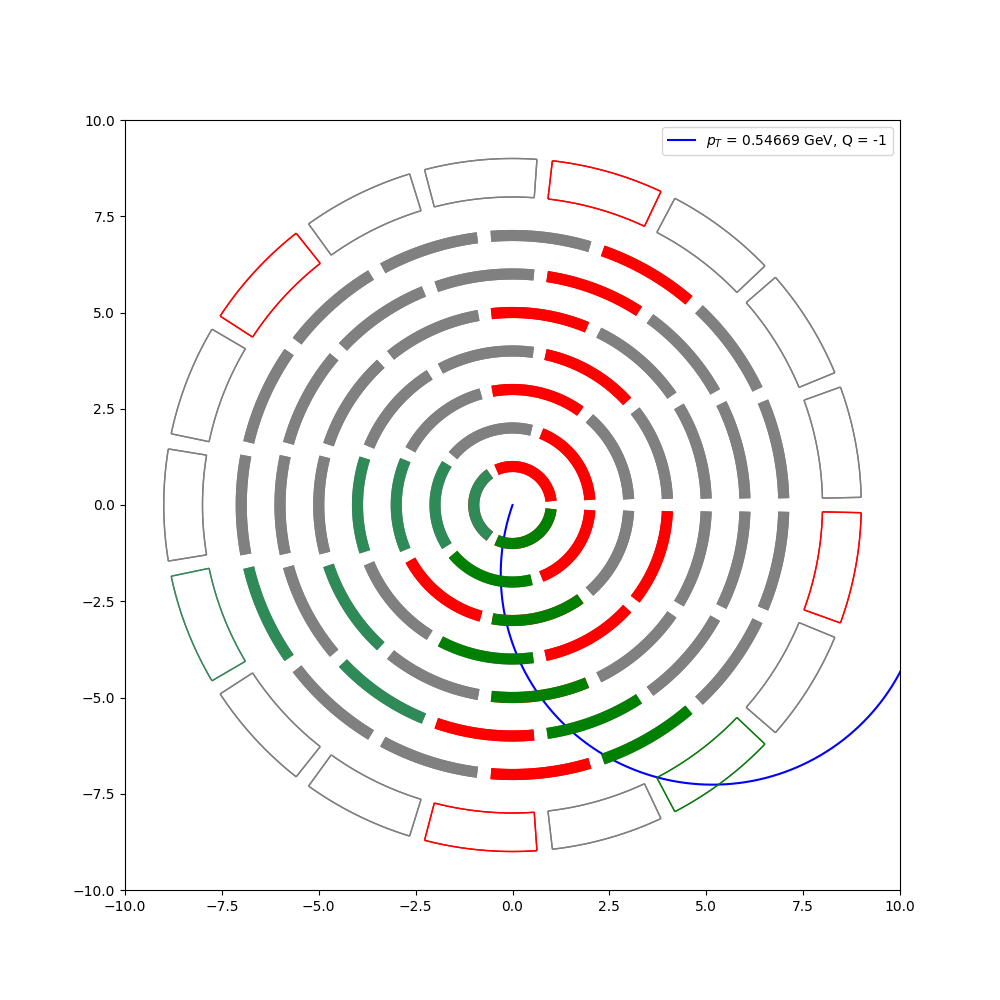

In [5]:
tw.show()

In [2]:
from matplotlib.colors import to_rgba_array, to_rgba
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [362]:
class ECal:
    def __init__(self, nrows, ncols, particles, max_hit, centercolor, crystal_edge = 1, noise = 0):
        column_names = ["x", "y", "edge", "content", "edgecolor", "facecolor", "center", "patch"]
        self.particles = particles
        self.n_particles = len(self.particles)
        self.crystals_df = pd.DataFrame(columns = column_names)
        self.particles = hits
        self.select_particles = deepcopy(self.particles)
        self.select_particles.loc[:,:] = 0
        counter = 0
        for c in range(ncols):
            for r in range(nrows):
                content = 0
                if np.random.rand() < noise:
                    content = np.random.rand()
                x = r*crystal_edge
                y =  c*crystal_edge
                edge = crystal_edge-0.1
                patch = Rectangle((x, y), edge, edge, edgecolor = "black", facecolor = "gray", linewidth = 1)
                self.crystals_df.loc[counter,column_names] = [x,y, edge, content, "black", "gray", False, patch]
                counter += 1
        for i in range(self.n_particles):
            self.crystals_df.loc[:,"content"] += self.particles.iloc[i].to_numpy()
        self.set_colors(0)
        self.collection = PatchCollection(self.crystals_df.loc[:,"patch"], match_original=True)
        colors = to_rgba_array(self.crystals_df.loc[:,"edgecolor"].to_numpy())
        self.collection.set_edgecolors(colors)
        
    
    def set_colors(self, selected_index):
        not_centers_mask = self.crystals_df.loc[:,"center"] == False
        self.crystals_df.loc[:,"facecolor"] = "gray"
        self.crystals_df.loc[:,"edgecolor"] = "black"
        selected_mask = self.select_particles.loc[selected_index,:].to_numpy()>0
        self.crystals_df.loc[selected_mask, "edgecolor"] = "green"
        hidden_mask = np.zeros(len(self.crystals_df))
        for i in range(self.n_particles):
            if i != selected_index:
                hidden_mask += self.select_particles.loc[i,:].to_numpy()
        hidden_mask = hidden_mask > 0
        self.crystals_df.loc[hidden_mask, "edgecolor"] = "seagreen"
        hit_mask = self.crystals_df["content"] > 0
        self.crystals_df.loc[hit_mask,"facecolor"] = "red"
    
    def get_crystal(self, rectangle):
        x,y = rectangle.get_xy()
        for i,r in enumerate(self.crystals):
            for j,c in enumerate(r):
                if x == c.x and y==c.y:
                    return i,j

In [369]:
import numpy as np
import pandas as pd

from matplotlib.widgets import LassoSelector
from matplotlib.path import Path

from copy import deepcopy


class ECLWidget:

    def __init__(self, ecal):
        self.ecal = ecal    
        #self.subplot_kw = dict(xlim=(-5,725), ylim=(-5,235), autoscale_on=False)
        
        fig, ax = plt.subplots(figsize=(16,9))#, subplot_kw=self.subplot_kw, dpi=400)
        ax.add_collection(self.ecal.collection)
        self.crystall_points = ax.scatter(ecal.crystals_df["x"], ecal.crystals_df["y"], s=0)
        self.xys = self.crystall_points.get_offsets()
        self.Npts = len(self.xys)
        self.canvas = ax.figure.canvas
        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []
        self.particle_index = 0
        self.crystal_helper = np.array([f'{i}' for i in np.arange(0, 6624)])
        
    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.ecal.select_particles.loc[self.particle_index, :] = 0
        self.ecal.select_particles.loc[self.particle_index, self.ind.astype(str)] = 1
        self.ecal.set_colors(self.particle_index)
        facecolors = to_rgba_array(self.ecal.crystals_df.loc[:,"facecolor"].to_numpy())
        edgecolors = to_rgba_array(self.ecal.crystals_df.loc[:,"edgecolor"].to_numpy())
        self.ecal.collection.set_edgecolors(edgecolors)
        self.ecal.collection.set_facecolors(facecolors)
        self.canvas.draw_idle()
        particle_mask = self.ecal.select_particles.loc[self.particle_index, :].to_numpy()>0
        energy = self.ecal.crystals_df.loc[particle_mask, "content"].sum()
        self.energy_label.value = f"Energy of selected Cluster: {str(round(energy,4))} GeV"
        
    def change_particle(self,change):
        self.particle_index = self.particle.value
        self.onselect([(0,0)])
        
    def show(self):
        self.particle = widgets.Dropdown(options = [i for i in range(self.ecal.n_particles)], value = 0, description = "Particle")
        self.particle.observe(self.change_particle, names = "value")
        self.energy_label = widgets.Label("Energy of selected Cluster: 0 GeV")
        self.box = widgets.HBox([self.particle, self.energy_label])
        self.out = widgets.Output()
        display(self.box, self.out)
        self.onselect([(0,0)])
        plt.show()
        
     

In [370]:
verts = [[1,1],[0,0]]

In [371]:
data = pd.read_hdf('EEEE/0_allcomb_0.h5')
coords = [f'{i}' for i in np.arange(0, 6624)]
hits = data[coords]
hits = hits.reset_index(drop=True)
hits

,0,1,2,3,4,5,6,7,8,9,...,6614,6615,6616,6617,6618,6619,6620,6621,6622,6623
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [372]:
max_hit = {}
for i in range(4):
    max_hit[int(hits.iloc[i].idxmax())] = i

In [373]:
ecal = ECal(144,46,hits, max_hit, centercolor, crystal_edge=5, noise = 0.01)

Output()

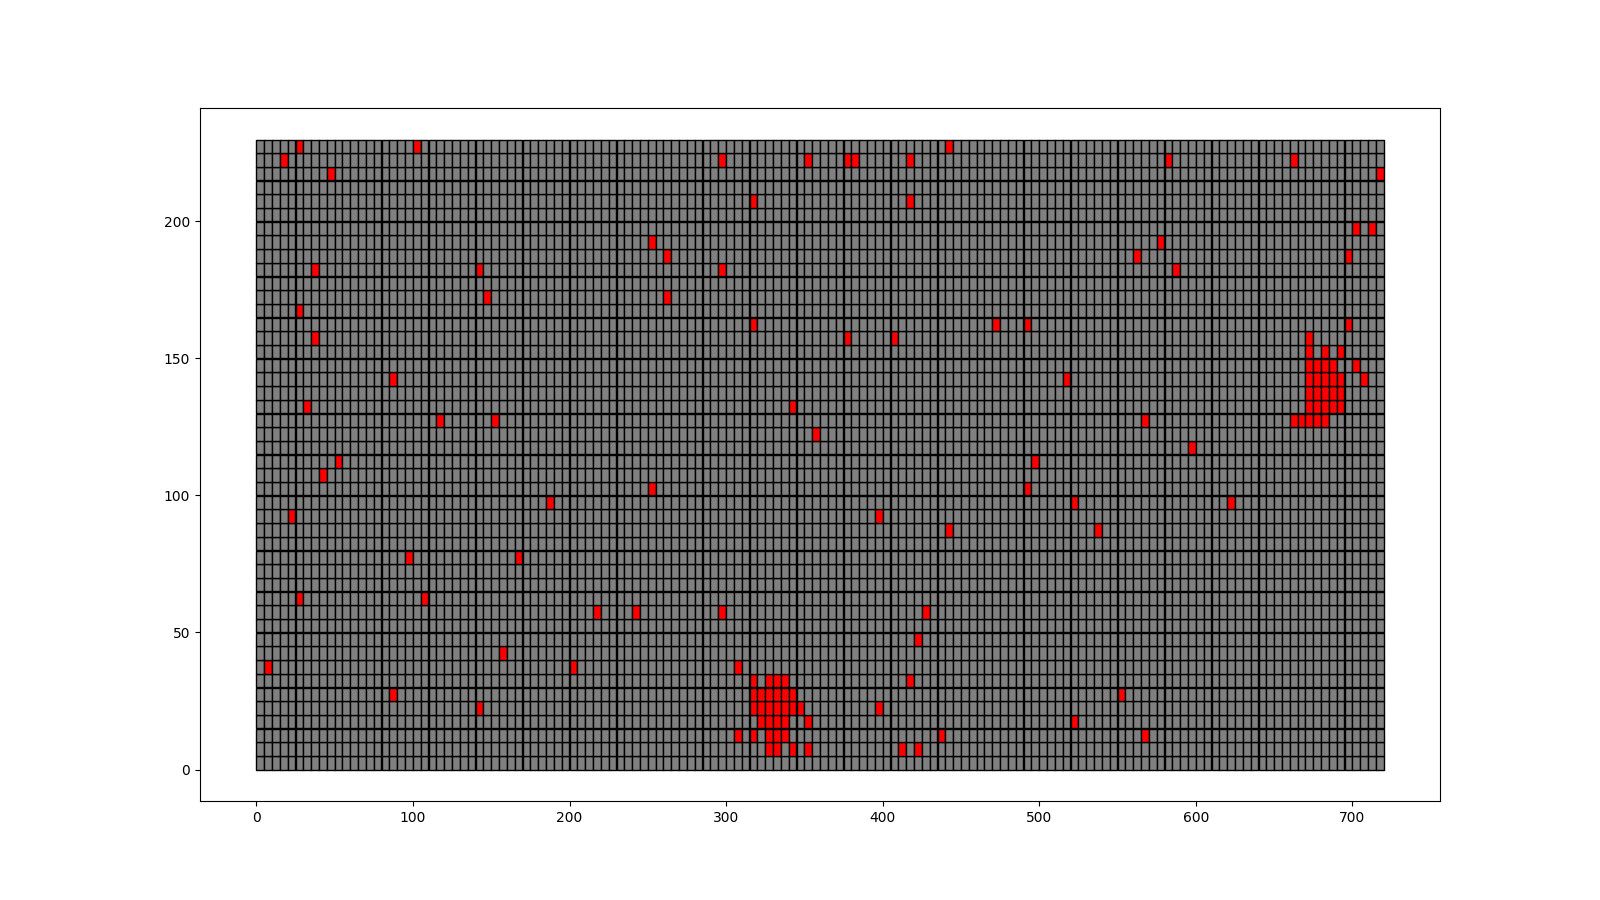

In [374]:
ew = ECLWidget(ecal)
ew.show()